In [70]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

# Load MNIST dataset
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()
(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]


In [71]:
# *** DOWNSAMPLE THE IMAGES ***
factor = 1/4

Xtrain_down = np.ones((ntrain, int(xdim*factor), int(ydim*factor)))
for i in range(ntrain):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((ntest, int(xdim*factor), int(ydim*factor)))
for i in range(ntest):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)


In [81]:
# *** VECTORIZE IMAGES ***
Xtrain_down = Xtrain_down.reshape(ntrain, int(xdim*factor)**2).astype('float32') / 255
Xtest_down = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
Xtrain = Xtrain.reshape(ntrain, xdim**2).astype('float32') / 255
Xtest = Xtest.reshape(ntest, xdim**2).astype('float32') / 255
# Categorical labels
Ytrain = np_utils.to_categorical(Ytrain, 10)
Ytest = np_utils.to_categorical(Ytest, 10)


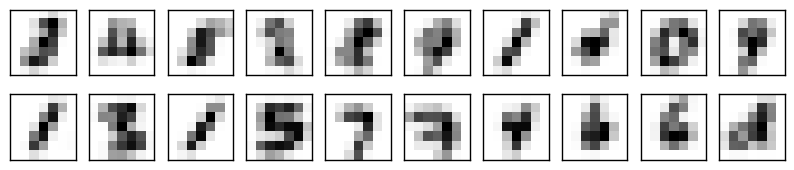

In [73]:
# *** VISUALIZATION 20 RANDOM TRAINING SAMPLES ***
# Create 20 subplots
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(2):
    for j in range(10):
        axes[i][j].imshow(Xtrain_down[np.random.randint(0, 6000),:].reshape(int(xdim*factor), 
                          int(ydim*factor)), cmap='gray_r', interpolation='nearest')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        

In [74]:
# # *** LDA ***
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Original images
# clf = LinearDiscriminantAnalysis()
# clf.fit(Xtrain, Ytrain)
# LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
#               solver='svd', store_covariance=False, tol=0.0001)

# # Returns the mean accuracy on the given test data and labels.
# score = clf.score(Xtest, Ytest, sample_weight=None)
# print(score)

# # Down-sampled images
# clf = LinearDiscriminantAnalysis()
# clf.fit(Xtrain_down, Ytrain)
# LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
#               solver='svd', store_covariance=False, tol=0.0001)

# # Returns the mean accuracy on the given test data and labels.
# score = clf.score(Xtest_down, Ytest, sample_weight=None)
# print(score)
# # print(clf.predict(Xtest))


/Users/elahe/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/elahe/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.873
0.8644


In [84]:
# *** TRAIN A FULLY-CONNECTED NN WITH TWO HIDDEN LAYERS ***
# create model
model = Sequential()
model.add(Dense(100, input_shape=(int(xdim*factor)**2,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(Xtrain_down, Ytrain, nb_epoch=50, batch_size=16)

# evaluate the model
scores = model.evaluate(Xtest_down, Ytest, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# # calculate predictions
# Ypredict = model.predict(Xtest)
# # round predictions
# rounded = [round(x[0]) for x in Ypredict]
# print(rounded)


/Users/elahe/anaconda3/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
60000/60000 [==============================] - 15s - loss: 1.8134 - acc: 0.3032    
Epoch 2/50
60000/60000 [==============================] - 14s - loss: 1.1683 - acc: 0.5814    
Epoch 3/50
60000/60000 [==============================] - 14s - loss: 1.0605 - acc: 0.6158    
Epoch 4/50
60000/60000 [==============================] - 15s - loss: 0.9991 - acc: 0.6431    
Epoch 5/50
60000/60000 [==============================] - 14s - loss: 0.9194 - acc: 0.6736    
Epoch 6/50
60000/60000 [==============================] - 14s - loss: 0.8046 - acc: 0.7160    
Epoch 7/50
60000/60000 [==============================] - 14s - loss: 0.6792 - acc: 0.7742    
Epoch 8/50
60000/60000 [==============================] - 14s - loss: 0.6215 - acc: 0.7994    
Epoch 9/50
60000/60000 [==============================] - 14s - loss: 0.5842 - acc: 0.8129    
Epoch 10/50
60000/60000 [==============================] - 15s - loss: 0.5402 - acc: 0.8288    
Epoch 11/50
60000/60000 [========================

In [97]:
# GET THE OUTPUT OF EACH LAYER AFTER TRAINING
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
#functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
layer_outs = functor([Xtest_down, 1.])
print(layer_outs)

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.023101  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.03259186],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.01482217],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.01421584],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.01554491]], dtype=float32), array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.06885444,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.43515649,  0.10050378],
       [ 0.02554294,  0.        ,  0.        , ...,  0.        ,
         0.23359326,  0.0940301 ],
       ..., 
       [ 0.19536428,  0.        ,  0.        , ...,  0. 